# Edit Distance and Linear Regression Analysis

## Based on Chancellor et al. (2016) RQ1 methodology: 

Chancellor, S., Pater, J. A., Clear, T., Gilbert, E., & De Choudhury, M. (2016). #Thyghgapp: Instagram Content Moderation and Lexical Variation in Pro-Eating Disorder Communities. _Proceedings of the 19th ACM Conference on Computer-Supported Cooperative Work & Social Computing_, 1201–1213. [https://doi.org/10.1145/2818048.2819963](https://doi.org/10.1145/2818048.2819963)

The Chancellor et al. paper examined how Instagram pro-eating disorder tag variants evolved after content moderation, finding that newer variants showed increasing syntactic distance from root tags.

This notebook demonstrates the calculation of Levenshtein edit distance for lexical variants and uses linear regression to test whether edit distance increases over time. It generates example data rather than relying on real data so that the notebook runs on its own.

## Load Modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta # maybe a new module for 313 students

## Define Helper Functions

We will need a function for calculating Levenshtein distance between two hashtags. 

In [2]:
def levenshtein_distance(s1, s2):
    """
    Calculate Levenshtein edit distance between two strings.
    
    The edit distance is the minimum number of single-character edits 
    (insertions, deletions, or substitutions) required to change one 
    word into another.
    
    Parameters:
    -----------
    s1, s2 : str
        The two strings to compare
        
    Returns:
    --------
    int : The edit distance between s1 and s2
    
    Example:
    --------
    >>> levenshtein_distance("thighgap", "thyghgapss")
    4
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    # Create matrix for dynamic programming
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # Cost of insertions, deletions, or substitutions
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

We also need a way to generate the data since we're using "toy" or "synthetic" data in this example notebook.

In [3]:
def create_example_data():
    """
    Create example data showing tag variants over time.
    
    Returns a simple DataFrame with columns 'root_tag', 'variant', 'weeks_since_root', and 'edit_distance'.
    """
    # Example tag chains similar to Chancellor et al.
    data = {
        'root_tag': [
            # fitness chain
            'fitness', 'fitness', 'fitness', 'fitness', 'fitness', 'fitness', 'fitness',
            # wellness chain  
            'wellness', 'wellness', 'wellness', 'wellness', 'wellness', 'wellness', 'wellness',
            # healthy chain
            'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy'
        ],
        'variant': [
            # fitness variants
            'fitness', 'fitnessss', 'fitnes', 'f1tness', 'fitnesss123', 'fiitnesss', 'fitttness',
            # wellness variants
            'wellness', 'wellnes', 'wellnessss', 'w3llness', 'wellnesslife', 'wellllness', 'wellnessss4',
            # healthy variants
            'healthy', 'healty', 'healthyyy', 'healthyy', 'h3althy', 'healthylife', 'healthyyyy', 'healllthy'
        ],
        'weeks_since_root': [
            # fitness timeline
            0, 4, 8, 12, 16, 20, 24,
            # wellness timeline
            0, 4, 8, 12, 16, 20, 24,
            # healthy timeline
            0, 4, 8, 12, 16, 20, 24, 28
        ]
    }
    
    df = pd.DataFrame(data)
    
    # Calculate edit distances
    df['edit_distance'] = df.apply(
        lambda row: levenshtein_distance(row['root_tag'], row['variant']),
        axis=1
    )
    
    return df

Let's wrap all the code for drawing the visualizations into one function too.

In [4]:
def visualize_with_seaborn(df):
    """
    Create visualizations using seaborn's built-in regression plotting.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'root_tag', 'weeks_since_root', and 'edit_distance' columns

    """
    
    # Get unique root tags
    root_tags = df['root_tag'].unique()
    n_tags = len(root_tags)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_tags, figsize=(15, 5))
    if n_tags == 1:
        axes = [axes]
    
    for idx, root_tag in enumerate(root_tags):
        ax = axes[idx]
        
        # Filter data for this tag
        tag_data = df[df['root_tag'] == root_tag]
        
        # regplot automatically adds regression line + confidence interval
        sns.regplot(
            data=tag_data,
            x='weeks_since_root',
            y='edit_distance',
            ax=ax,
            scatter_kws={'s': 100, 'alpha': 0.6},
            line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2}
        )
        
        # Formatting
        ax.set_xlabel('Weeks Since Root Tag', fontsize=11)
        ax.set_ylabel('Levenshtein Edit Distance', fontsize=11)
        ax.set_title(f'Tag Chain: "{root_tag}"', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Analysis

Now we'll replicate the type of analysis the Chancellor et al. paper did for RQ1: 

> RQ 1. (Lexical  Changes)  How  do  lexical  variations  of moderated pro-ED tags evolve over time?

In [5]:
 # Generate example data
print("\n1. Generating example tag variant data...")
df = create_example_data()
print(f"   Created {len(df)} tag variants across {df['root_tag'].nunique()} root tags")

df.head()


1. Generating example tag variant data...
   Created 22 tag variants across 3 root tags


,root_tag,variant,weeks_since_root,edit_distance
0,fitness,fitness,0,0
1,fitness,fitnessss,4,2
2,fitness,fitnes,8,1
3,fitness,f1tness,12,1
4,fitness,fitnesss123,16,4


In [6]:
# Show example of edit distance calculation
print("\nExample Levenshtein distance calculations:")
examples = [
    ("fitness", "fitnessss"),
    ("wellness", "w3llness"),
    ("healthy", "healthylife")
]
for s1, s2 in examples:
    dist = levenshtein_distance(s1, s2)
    print(f"   '{s1}' → '{s2}': edit distance = {dist}")


Example Levenshtein distance calculations:
   'fitness' → 'fitnessss': edit distance = 2
   'wellness' → 'w3llness': edit distance = 1
   'healthy' → 'healthylife': edit distance = 4


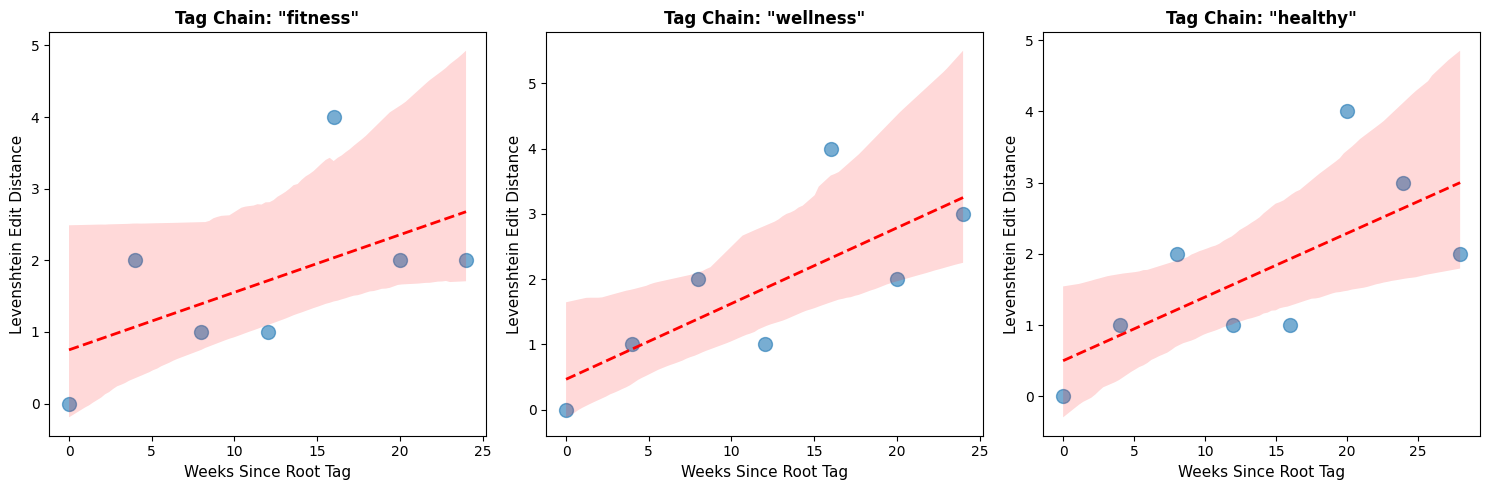

In [7]:
# Plot the data with seaborn
visualize_with_seaborn(df)

In [8]:
# Test whether edit distance increases significantly over time
model = sm.OLS.from_formula('edit_distance ~ weeks_since_root', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          edit_distance   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     15.13
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           0.000911
Time:                        14:58:50   Log-Likelihood:                -29.095
No. Observations:                  22   AIC:                             62.19
Df Residuals:                      20   BIC:                             64.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5897      0.366  